In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get NBA data
playerData = pd.read_csv('../NBAPlayerData/Players.csv')
playerStats = pd.read_csv('../NBAPlayerData/Seasons_Stats.csv')

# Get the players that play since 2000
playerStats = playerStats[playerStats['Year']>=2000]
# Only look at players who have played more than 20 games
playerStats = playerStats[playerStats["G"]>30]
# Only look at players who have played more than minutes
playerStats = playerStats[playerStats["MP"]>300]
playerData = playerData[playerData['Player'].isin(playerStats['Player'])]

# Merge the datasets
playerStats = playerStats.merge(playerData, on="Player")

# Make some of the columns we need
playerStats['PPG'] = playerStats['PTS']/playerStats['G']
playerStats['PPM'] = playerStats['PTS']/playerStats['MP']
playerStats['AST_per_TOV'] = [playerStats['AST'].iloc[i]/playerStats['TOV'].iloc[i] if playerStats['TOV'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['MP_per_PF'] = [playerStats["PF"].iloc[i]/playerStats["MP"].iloc[i] if playerStats['MP'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['FTA_per_FGA'] = [playerStats["FTA"].iloc[i]/playerStats["FGA"].iloc[i] if playerStats['FGA'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['MP_per_3PA'] = [playerStats["MP"].iloc[i]/playerStats["3PA"].iloc[i] if playerStats['3PA'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]
playerStats['PTS_per_FGA'] = [playerStats["PTS"].iloc[i]/playerStats["FGA"].iloc[i] if playerStats['FGA'].iloc[i]!=0 else np.nan for i in range(len(playerStats))]

# Rename some columns
playerStats.rename(columns={"weight":"WEIGHT", "height":"HEIGHT"}, inplace=True)

# Create the position columns
playerStats["G"] = [1 if "G" in playerStats['Pos'].iloc[i] else 0 for i in range(len(playerStats))]
playerStats["F"] = [1 if "F" in playerStats['Pos'].iloc[i] else 0 for i in range(len(playerStats))]
playerStats["C"] = [1 if "C" in playerStats['Pos'].iloc[i] else 0 for i in range(len(playerStats))]

# Fill in missing values
playerStats["3P%"] = playerStats['3P%'].fillna(0)
playerStats["FT%"] = playerStats['FT%'].fillna(0)
playerStats["MP_per_3PA"] = playerStats['MP_per_3PA'].fillna(np.mean(playerStats['MP_per_3PA']))
impute_mean_cols = ['AST_per_TOV', 'MP_per_PF', 'FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA']
# for col in impute_mean_cols:
#     playerStats[col] = playerStats.fillna(np.mean(playerStats.loc[playerStats[col].isnull()==False]))[col]

In [3]:
# Define the columns we want to cluster on 
simCols = ['FT%', '3P%', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'USG%', 'OWS', 'DWS', 'FTA',
              '3PA', 'PTS', 'PF', 'MP_per_PF', 'FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA',
              'C', 'F', 'G', 'PPM', 'PPG', 'HEIGHT', 'WEIGHT']

# Standard scale everything
from sklearn.preprocessing import StandardScaler
scaledData = playerStats.copy()
scaler = StandardScaler()
scaledData[simCols] = scaler.fit_transform(scaledData[simCols])

In [4]:
# START THE CLUSTERING !!!!

# Do it with three clusters - seems natural
from sklearn.cluster import KMeans
N = 3
kmeans = KMeans(n_clusters=N).fit(scaledData[simCols].values)
scaledData['k_means_label'] = kmeans.labels_

print("Cluster Sizes:", [len(scaledData[scaledData["k_means_label"]==l]) 
                          for l in scaledData["k_means_label"].unique()])

Cluster Sizes: [3203, 1586, 2061]


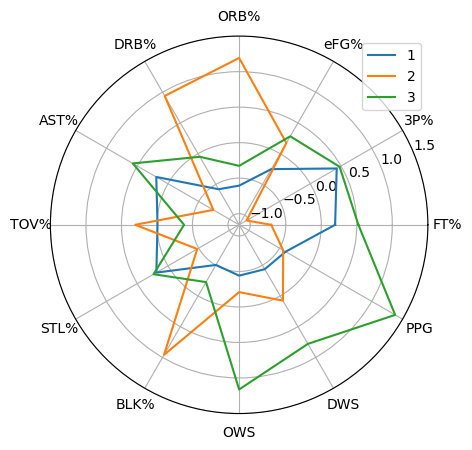

In [5]:
columnNames = ['FT%', '3P%', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'OWS', 'DWS', 'PPG']
# columns = simCols
N = len(columnNames)
columns = [True if col in columnNames else False for col in simCols]
l = ["1", "2", "3"]
centers = kmeans.cluster_centers_
plt.figure(figsize=(6,5), dpi=100)
for i in range(len(centers)):
    center = list(centers[i][columns])
    center += center[:1]
    angles = [n/float(N)*2*np.pi for n in range(N)]
    angles += angles[:1]
    
    plt.polar(angles, center, label=l[i])
plt.legend()
plt.xticks(angles[:-1], columnNames)
plt.show()

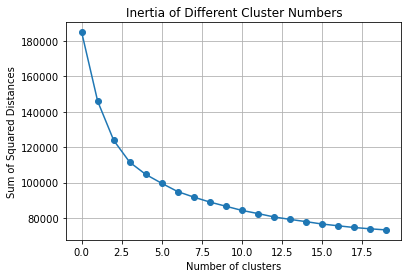

In [6]:
# Do it with the elbow technique
points = 20
scores = [KMeans(n_clusters=i+1).fit(scaledData[simCols].values).inertia_
          for i in range(points)]

plt.plot(range(points), scores, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Distances")
plt.title('Inertia of Different Cluster Numbers')
plt.grid()
plt.show()

In [7]:
# Try a different type of clustering
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=300).fit(scaledData[simCols].values)
scaledData["OPTICS_label"] = optics.labels_

print("Number of clusters:", len(scaledData["OPTICS_label"].unique()))
print("Cluster Counts:", [len(scaledData[scaledData["OPTICS_label"]==l]) 
                          for l in scaledData["OPTICS_label"].unique()])

Number of clusters: 1
Cluster Counts: [6850]


In [8]:
# Try a different type of clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(min_samples=300, eps=1).fit(scaledData[simCols].values)
scaledData["DBSCAN_label"] = dbscan.labels_

print("Number of clusters:", len(scaledData["DBSCAN_label"].unique()))
print("Cluster Counts:", [len(scaledData[scaledData["DBSCAN_label"]==l]) 
                          for l in scaledData["DBSCAN_label"].unique()])

Number of clusters: 1
Cluster Counts: [6850]


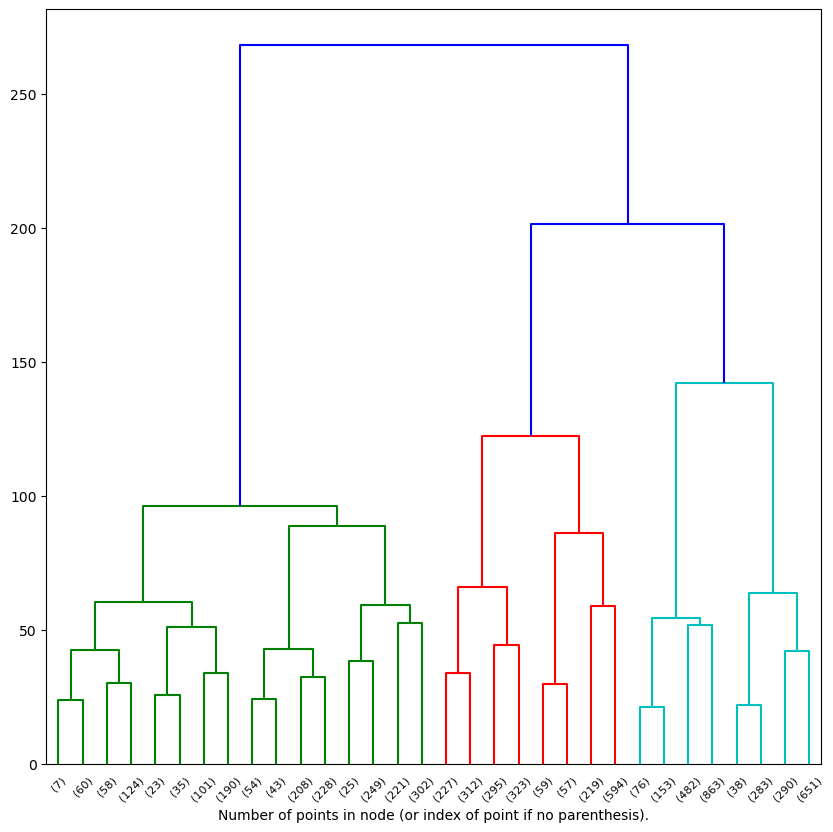

In [9]:
# Try a different type of clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(scaledData[simCols])

plt.figure(figsize=(10,10), dpi=100)
plot_dendrogram(model, truncate_mode="level", p=4, color_threshold=150)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


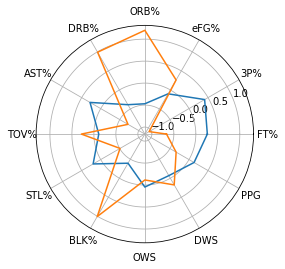

In [10]:
# Now print some of the clusters!
model = AgglomerativeClustering()
model = model.fit(scaledData[simCols])
scaledData["Agg_label"] = model.labels_
columnNames = ['FT%', '3P%', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'OWS', 'DWS', 'PPG']
# columns = simCols
N = len(columnNames)
columns = [True if col in columnNames else False for col in simCols]
labels = scaledData["Agg_label"].unique()
centers = [scaledData[scaledData["Agg_label"]==l][simCols].mean().values for l in labels]

for i in range(len(centers)):
    center = list(centers[i][columns])
    center += center[:1]
    angles = [n/float(N)*2*np.pi for n in range(N)]
    angles += angles[:1]
    
    plt.polar(angles, center)
    
plt.xticks(angles[:-1], columnNames)
plt.show()

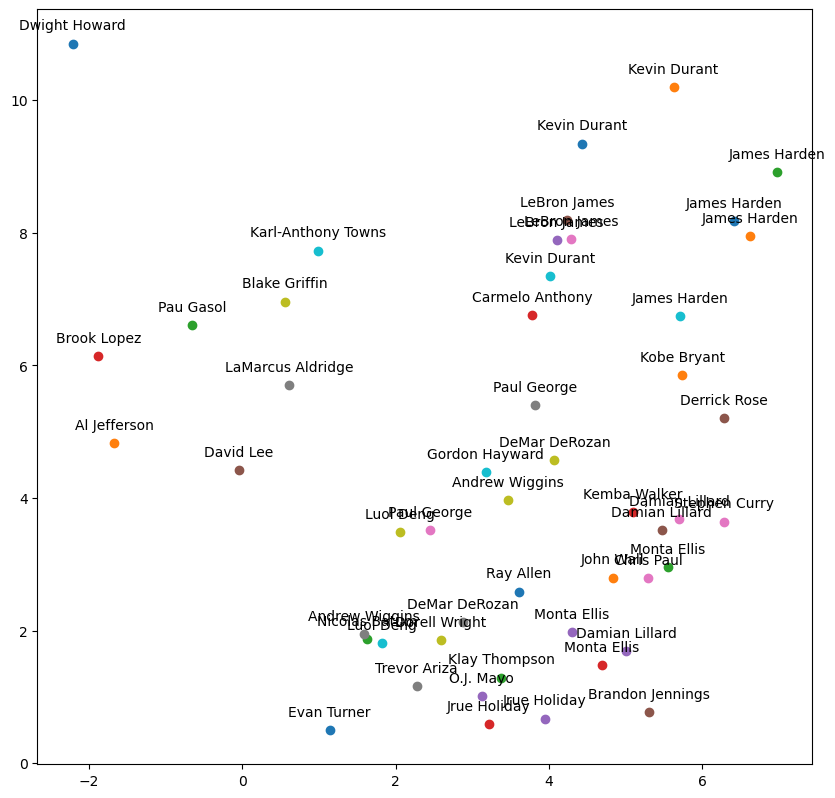

In [11]:
# NOW WE WILL TRY PCA AND SEE WHAT HAPPENS
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
decomposed = pca.fit_transform(scaledData[simCols])
# decomposed = pca.fit_transform(playerStats[simCols])

# Find players that played the most minutes and see where they end up on the graph
subset = playerStats[playerStats["Year"]>2010]
mostMin = subset[subset["MP"]>max(subset["MP"])*0.89]
mostMinD = decomposed[mostMin.index]

plt.figure(figsize=(10,10), dpi=100)
for i in range(len(mostMin)):
    x, y, name = mostMinD[i][0], mostMinD[i][1], mostMin["Player"].iloc[i]
    plt.plot(x, y, "o")
    plt.annotate(name, (x, y), textcoords='offset points', xytext=(0,10), ha='center')

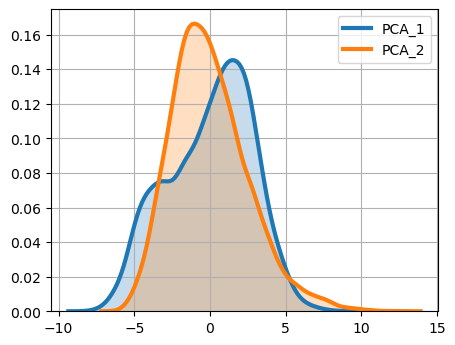

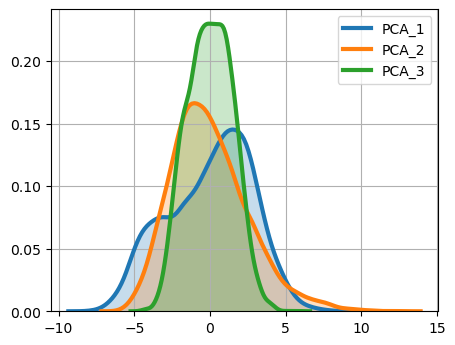

In [12]:
# Show both columns distributions
plt.figure(figsize=(5,4), dpi=100)
sns.distplot(decomposed[:,0], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="PCA_1")
sns.distplot(decomposed[:,1], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="PCA_2")
plt.grid()
plt.show()

pca = PCA(n_components=3)
decomposed = pca.fit_transform(scaledData[simCols])
plt.figure(figsize=(5,4), dpi=100)
sns.distplot(decomposed[:,0], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="PCA_1")
sns.distplot(decomposed[:,1], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="PCA_2")
sns.distplot(decomposed[:,2], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="PCA_3")
plt.grid()
plt.show()

In [13]:
# Look at team distribution of each labels

teamDist1, teamDist2, teamDist3 = [], [], []
for team in scaledData['Tm'].unique():
    for year in scaledData["Year"].unique():
        teamYear = scaledData[(scaledData["Tm"]==team) & (scaledData["Year"]==year)]
        if len(teamYear)>1:
            teamDist1.append(len(teamYear[teamYear["k_means_label"]==0]))
            teamDist2.append(len(teamYear[teamYear["k_means_label"]==1]))
            teamDist3.append(len(teamYear[teamYear["k_means_label"]==2]))


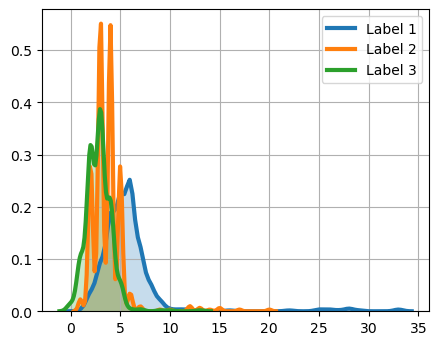

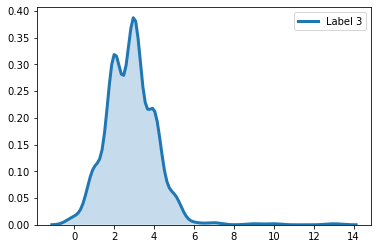

In [14]:
plt.figure(figsize=(5,4), dpi=100)
sns.distplot(teamDist1, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="Label 1")
sns.distplot(teamDist2, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="Label 2")
sns.distplot(teamDist3, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="Label 3")
plt.grid()
plt.show()

teamSize = [teamDist1[i]+teamDist2[i]+teamDist3[i] for i in range(len(teamDist2))]
sns.distplot(teamDist3, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label="Label 3")